<a href="https://colab.research.google.com/github/theindianwriter/cs6910_assignment1/blob/main/Version_2_DL_Assigment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy.special import expit
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

In [2]:
from keras.datasets import fashion_mnist

In [3]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.0MB 5.8MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
     |████████████████████████████████| 133kB 32.9MB/s 
     |████████████████████████████████| 163kB 35.7MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
def data_loader():
    
  (x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
  num_of_train_data = x_train.shape[0]
  combined_training_data = list(zip(x_train,y_train))
  np.random.shuffle(combined_training_data)
  (x_train,y_train) = zip(*combined_training_data)
  x_train,y_train = np.array(x_train),np.array(y_train)
  validation_size = int(0.1*num_of_train_data)
  x_validation = x_train[:validation_size]
  y_validation = y_train[:validation_size]
  x_train = x_train[validation_size:]
  y_train = y_train[validation_size:]
  return x_train,y_train,x_validation,y_validation,x_test,y_test


In [5]:
x_train,y_train,x_validation,y_validation,x_test,y_test = data_loader()
print("information regarding the training,validation and test dataset")
print("the size of training dataset is {},validation set is {},test set is {}".format(x_train.shape[0],x_validation.shape[0],x_test.shape[0]))

4423680/4422102 [==============================] - 0s 0us/step
information regarding the training,validation and test dataset
the size of training dataset is 54000,validation set is 6000,test set is 10000


In [6]:
def vectorize(Y):
  Y_vectorize = np.zeros((Y.shape[0],10))
  for i in range(Y.shape[0]):
      Y_vectorize[i][Y[i]] = 1.0
  return Y_vectorize

In [7]:
def prep_data(X,Y):
    X_vector = np.array([np.reshape(x,(784))for x in X])
    # mean = np.mean(X_vector,axis = 0)
    # std = np.std(X_vector,axis = 0)
    X_norm_vector = (X_vector/255.0)
    Y_vectorize = vectorize(Y)
    return X_norm_vector,Y_vectorize

In [8]:
class_label = ['T-shirt/top', 
           'Trousers', 
           'Pullover', 
           'Dress', 'Coat', 
           'Sandal', 
           'Shirt', 
           'Sneaker', 
           'Bag', 
           'Ankle boot']

In [9]:
#Q1 plots one image of each class 

def plot_each_label(X,Y):
  rows = 2
  cols = 5
  fig = plt.figure()
  ax = []
  j = 0
  for i in range(1,rows*cols + 1):
    ax.append(fig.add_subplot(rows,cols,i))
    pos = np.where(Y == j)
    plt.imshow(X[pos[0][0]])
    plt.xticks([])
    plt.yticks([])
    ax[-1].set_title(class_label[j])
    j += 1
  plt.show()


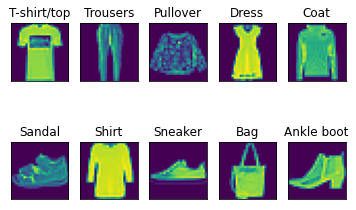

In [10]:
#Q1 calls and plots image of each class
plot_each_label(x_train,y_train)

In [11]:
def softmax(X):
    output = np.zeros(X.shape)
    for col in range(X.shape[1]):
        exps = np.exp(X[:,col] - np.max(X[:,col]))
        output[:,col] = exps/exps.sum()

    return output

def sigmoid(X):
    return expit(X) #to avoid overflow

def sigmoid_derivative(x):
  return sigmoid(x)*(1-sigmoid(x))

def tanh(X):
    return np.tanh(X)

def relu(X,alpha = 0):
    X = np.array(X,dtype=np.float64)
    return np.where(X<0,0.001*X,X)

def tanh_derivative(X):
    return (1-np.square(tanh(X)))

def relu_derivative(X):
    X_relu = np.ones_like(X,dtype=np.float64)
    X_relu[X < 0] = 0.001
    return X_relu


  

In [12]:
class Network:

# ---------------------------------------START OF NETWORK INITIALIAZATION ---------------------------------------------
#----------------------------------------------------------------------------------------------------------------------
  #initialization of the network
  def __init__(self,layers,weight_initilizer = "random"):
    print(layers)
    self.num_of_layers = len(layers)
    self.layers = layers
    self.num_of_steps = 0
    np.random.seed(1234)

    #based on the methods the initilization would be done
    if weight_initilizer == 'random':
      self.random(layers)
    elif weight_initilizer == 'Xavier':
      self.Xavier(layers)
    else:
      print("ERROR")

    #used for mpmentum based gradient descent,adam and nadam
    self.prev_update_biases = [np.zeros((x,1)) for x in layers[1:]]
    self.prev_update_weights = [np.zeros((x,y)) for x,y in zip(layers[1:],layers[:-1])]
    #used for adam,rmsprop and nadam
    self.v_w = [np.zeros((x,y)) for x,y in zip(layers[1:],layers[:-1])]
    self.v_b = [np.zeros((x,1)) for x in layers[1:]]

#--------------------------------------END OF INITIALIZATION OF NETWORK------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

#-----------------------------------------START OF INITILIZATION OF WEIGHTS AND BIASES METHODS ------------------------------
#---------------------------------------------------------------------------------------------------------------------------

  def random(self,layers):
    self.biases = [np.random.randn(x,1) for x in layers[1:]]
    self.weights = [np.random.randn(x,y) for x,y in zip(layers[1:],layers[:-1])]

  def Xavier(self,layers):
    self.biases = [np.random.randn(x,1) for x in layers[1:]]
    self.weights = [np.random.randn(x,y)*2/np.sqrt(y+x) for x,y in zip(layers[1:],layers[:-1])]

#-------------------------------------------END OF INITIALIZATION OF WEIGHTS AND BIASES METHOD-------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------START OF CALCULATING LOSS FUNCTIONS ----------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------

  def calculate_loss(self,Y,Y_predicted):
    if self.loss == "cross_entropy_loss":
        error = log_loss(Y,Y_predicted)
        return error
    elif self.loss == "squared-error":
        error = mean_squared_error(Y,Y_predicted)
        return error
#--------------------------------------------------END OF CALCULATING LOSS FUNCTIONS------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------

#-----------------------------------------------------------START OF ACTIVATION FUNCTION METHODS ----------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------

  def perform_activation(self,A):
 
    if self.activation == 'sigmoid':
      return sigmoid(A)
    elif self.activation == "tanh":
      return tanh(A)
    elif self.activation == "relu":
        return relu(A)
    else:
      print("ERROR")

  def perform_output_function(self,A):

    if self.output_function == "softmax":
      H = softmax(A)
    else:
      print("ERROR")
    return H
#--------------------------------------------------END OF ACTIVATION FUNCTION METHODS-----------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------



  def update_parameter(self,grad_wrt_weights,grad_wrt_biases,eta,gamma = 0.5,beta1 = 0.9,beta2 = 0.999,eps = 1e-08):
    if self.optimizer == "sgd":
        update_wrt_biases = [eta*gb for gb in grad_wrt_biases]
        update_wrt_weights = [eta*gw for gw in grad_wrt_weights]

    elif self.optimizer == "momentum":
        update_wrt_biases = [gamma*ub + eta*gb for ub,gb in zip(self.prev_update_biases,grad_wrt_biases)]
        update_wrt_weights = [gamma*uw + eta*gw for uw,gw in zip(self.prev_update_weights,grad_wrt_weights)]

        self.prev_update_biases = update_wrt_biases
        self.prev_update_weights = update_wrt_weights

    elif self.optimizer == "nesterov":

        update_wrt_biases = [gamma*ub + eta*gb for ub,gb in zip(self.prev_update_biases,grad_wrt_biases)]
        update_wrt_weights = [gamma*uw + eta*gw for uw,gw in zip(self.prev_update_weights,grad_wrt_weights)]

        self.prev_update_biases = update_wrt_biases
        self.prev_update_weights = update_wrt_weights
        
    #not able to perform well in rmsprop
    elif self.optimizer == "rmsprop":

        self.v_b = [beta2*t + (1-beta2)*np.square(gb) for t,gb in zip(self.v_b,grad_wrt_biases)]
        self.v_w = [beta2*t + (1-beta2)*np.square(gw) for t,gw in zip(self.v_w,grad_wrt_weights)] 
        
        update_wrt_biases = [eta*(gb/(np.sqrt(vb)+eps)) for vb,gb in zip(self.v_b,grad_wrt_biases)]
        update_wrt_weights = [eta*(gw/(np.sqrt(vw)+eps)) for vw,gw in zip(self.v_w,grad_wrt_weights)]


    elif self.optimizer == "adam":
        i = self.num_of_steps - 1

        self.prev_update_biases =  [(beta1*mb + (1-beta1)*gb)for mb,gb in zip(self.prev_update_biases,grad_wrt_biases)] 
        self.prev_update_weights = [(beta1*mw + (1-beta1)*gw) for mw,gw in zip(self.prev_update_weights,grad_wrt_weights)] 

        # m_b_hat = [mb*(1-np.power(beta1,i)) for mb in m_b]
        # m_w_hat = [mw*(1-np.power(beta1,i)) for mw in m_w]

        self.v_w = [(beta2*vw + (1-beta2)*(np.square(gw))) for vw,gw in zip(self.v_w,grad_wrt_weights)] 
        self.v_b = [(beta2*vb + (1-beta2)*(np.square(gb))) for vb,gb in zip(self.v_b,grad_wrt_biases)]

        # v_b_hat = [(vb/np.power(beta2,i)) for vb in self.v_b]
        # v_w_hat = [(vw/np.power(beta2,i)) for vw in self.v_w]
        eta =  eta*np.sqrt((1-beta2**i)/((1-beta1**i)+eps))
        update_wrt_biases = [eta*(mb/(np.power(vb,0.5)+eps)) for vb,mb in zip( self.v_b,self.prev_update_biases)]
        update_wrt_weights = [eta*(mw/(np.power(vw,0.5)+eps)) for vw,mw in zip(self.v_w,self.prev_update_weights)]

        # self.prev_update_biases = m_b
        # self.prev_update_weights = m_w
        # print(self.prev_update_biases)

    elif self.optimizer == "nadam":
        i = self.num_of_steps - 1

        m_b =  [(beta1*mb + (1-beta1)*gb)for mb,gb in zip(self.prev_update_biases,grad_wrt_biases)] 
        m_w = [(beta1*mw + (1-beta1)*gw) for mw,gw in zip(self.prev_update_weights,grad_wrt_weights)] 

        m_b_hat = [mb*(1-np.power(beta1,i)) for mb in m_b]
        m_w_hat = [mw*(1-np.power(beta1,i)) for mw in m_w]

        self.v_w = [(beta2*vw + (1-beta2)*(np.power(gw,2))) for vw,gw in zip(self.v_w,grad_wrt_weights)] 
        self.v_b = [(beta2*vb + (1-beta2)*(np.power(gb,2))) for vb,gb in zip(self.v_b,grad_wrt_biases)]

        v_b_hat = [(vb/np.power(beta2,i)) for vb in self.v_b]
        v_w_hat = [(vw/np.power(beta2,i)) for vw in self.v_w]

        update_wrt_biases = [(eta/np.power(vb+eps,0.5))*mb for vb,mb in zip(v_b_hat,m_b_hat)]
        update_wrt_weights = [(eta/np.power(vw+eps,0.5))*mw for vw,mw in zip(v_w_hat,m_w_hat)]

        self.prev_update_biases = m_b
        self.prev_update_weights = m_w
        

    #updation of the parameters
    self.weights = [w - grad_w for w,grad_w in zip(self.weights,update_wrt_weights)]
    self.biases = [b - grad_b for b,grad_b in zip(self.biases,update_wrt_biases)]


    


  def forward_propagation(self,X):
    #input vector to the network
    A_h = X.T
    #array to store pre-activation vectors of the hidden layers and output layer
    A = []
    #array to store post activation vectors of the input layer,hidden layers and ouput layer
    H = [X.T]
    for w,b in zip(self.weights[:-1],self.biases[:-1]):
      A_h = np.dot(w,A_h)+ b
      A.append(A_h)
      H_i = self.perform_activation(A_h)
      H.append(H_i)

    #calculating the pre-activation and post-activation vector in the output layer
    w,b = self.weights[-1],self.biases[-1]
    A_o = np.dot(w,A[-1]) + b
    A.append(A_o)
    H_o = self.perform_output_function(A_o)
    H.append(H_o)
    return A,H,H[-1]


  def get_delta_hidden_layer(self,grad_wrt_weight,delta,A):
        if self.activation == "sigmoid":
            return np.dot(grad_wrt_weight.T,delta)*(sigmoid_derivative(A))
        elif self.activation == "tanh":
            return np.dot(grad_wrt_weight.T,delta)*(tanh_derivative(A))
        elif self.activation == "relu":
            return np.dot(grad_wrt_weight.T,delta)*(relu_derivative(A))

  def get_delta_last_layer(self,A,H,Y):

    if self.loss == "cross_entropy_loss":
      delta = H - Y.T
      return delta
    elif self.loss == "squared-error":
      delta = (H - Y.T)*H*(1-H)
      return delta

  def backward_propagation(self,X,Y,A,H,l2 = 0.3):

    grad_wrt_weights = [np.zeros(w.shape) for w in self.weights]
    grad_wrt_biases = [np.zeros(b.shape) for b in self.biases]
    N = X.shape[0]
    delta = self.get_delta_last_layer(A[-1],H[-1],Y)
    grad_wrt_biases[-1] = (1/N)*np.sum(delta,axis = 1,keepdims = True)
    grad_wrt_weights[-1] = (1/N)*np.dot(delta,H[-2].T)
    for l in range(2,self.num_of_layers):
      delta = self.get_delta_hidden_layer(grad_wrt_weights[-l+1],delta,A[-l])
      grad_wrt_biases[-l] = (1/N)*np.sum(delta,axis = 1,keepdims = True)
      grad_wrt_weights[-l] = (1/N)*np.dot(delta,H[-l-1].T) + ((l2 * self.weights[-l])/N)
      
    return grad_wrt_weights,grad_wrt_biases

  def fit(self,x_train,y_train,x_val,y_val,epochs = 5, eta = 0.001,gamma = 0.5,batch_size = 64,beta1 = 0.9,l2 = 0):
      
    N = x_train.shape[0]
    prev_accuracy = 0
    max_accuracy = 0
    for epoch in range(1,epochs+1):
        batch_error = 0
        combined_training_data = list(zip(x_train,y_train))
        np.random.shuffle(combined_training_data)
        x_train[:],y_train[:] = zip(*combined_training_data)
        x_train,y_train = np.array(x_train),np.array(y_train)

        mini_x_batches = [x_train[i:i+batch_size] for i in range(0,N,batch_size)]
        mini_y_batches = [y_train[i:i+batch_size] for i in range(0,N,batch_size)] 

        for X,Y in zip(mini_x_batches,mini_y_batches):
            #only for nestorov accelerated gradient descent
            self.num_of_steps += 1
            if self.optimizer == "nesterov":
                self.biases = [b - gamma*ub for b,ub in zip(self.biases,self.prev_update_biases)]
                self.weights = [w - gamma*uw  for w,uw in zip(self.weights,self.prev_update_weights)]

            if self.optimizer == "nadam":
                self.biases = [b - beta1*ub*(1-np.power(beta1,self.num_of_steps)) for b,ub in zip(self.biases,self.prev_update_biases)]
                self.weights = [w - beta1*uw*(1-np.power(beta1,self.num_of_steps)) for w,uw in zip(self.weights,self.prev_update_weights)]

            #forward propagation
            A,H,Y_predicted = self.forward_propagation(X)
            #backward propagation
            grad_wrt_weights,grad_wrt_biases = self.backward_propagation(X,Y,A,H,l2)
            #gradient descent variant
            self.update_parameter(grad_wrt_weights,grad_wrt_biases,eta,gamma)
            batch_error += self.calculate_loss(Y.T,Y_predicted)

        loss = batch_error/N
        accuracy_val = self.test(x_val,y_val)

        if(max_accuracy - accuracy_val) > 4.0:
            break

        max_accuracy = max(max_accuracy,accuracy_val)
        
        #for annealing the learning rate just a heuristic
        if (prev_accuracy - accuracy_val) > 0.5:
            eta = eta/2
        prev_accuracy = accuracy_val


        print("In epoch {} the loss for train set is {}".format(epoch,loss))
        print("In epoch {} the accuracy for validation set is {} %".format(epoch,accuracy_val))
        wandb.log({"epoch": epoch,"accuracy" : accuracy_val,"training loss":loss })
        print("---------------------------------------------------------\n")
        

  def compile(self,optimizer = "sgd",loss = "squared-error",activation = "sigmoid",output_function = "softmax",metrics = "accuracy"):

    self.activation = activation
    self.output_function = output_function
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics


  def test(self,X,Y):
    if self.metrics == "accuracy":
        A,H,Y_predicted = self.forward_propagation(X)
        Y_list = np.argmax(Y.T,axis = 0).reshape(Y.T.shape[1], 1)
        Y_list_predicted = np.argmax(Y_predicted,axis = 0).reshape(Y.T.shape[1], 1)
        accuracy_matrix = Y_list_predicted == Y_list
        accuracy_list = list(accuracy_matrix)
        correct = accuracy_list.count([True])
        return round(((correct*100)/len(accuracy_list)),2)



In [13]:
x_train_transformed,y_train_transformed = prep_data(x_train,y_train)

In [14]:
x_val_transformed,y_val_transformed = prep_data(x_validation,y_validation)

In [15]:
x_test_transformed,y_test_transformed = prep_data(x_test,y_test)

In [ ]:
#----------------------------------PREPARE THE TRAINING DATA BEFORE --------------------------------

In [16]:
defaults = dict(
    num_of_hidden_layers = 3,
    size_of_hidden_layer = 64,
    optimizer = "sgd",
    loss = "cross_entropy_loss",
    activation = "sigmoid",
    output_function = "softmax",
    metrics = "accuracy",
    learning_rate = 0.001,
    gamma = 0.5,
    epochs = 5,
    batch_size = 64,
    weight_initializer = "Xavier",
    l2 = 0.5
)

wandb.init(project="CS6910-assignment1",config = defaults)
config = wandb.config

wandb: Currently logged in as: theindianwriter (use `wandb login --relogin` to force relogin)


In [17]:
layers = [784,10]
for i in range(config.num_of_hidden_layers):
    layers.insert(1,config.size_of_hidden_layer)


net = Network(layers,weight_initilizer=config.weight_initializer)
net.compile(optimizer = config.optimizer,loss = config.loss,activation = config.activation,output_function = config.output_function,metrics = config.metrics)

net.fit(x_train_transformed,y_train_transformed,x_val_transformed,y_val_transformed,epochs = config.epochs, eta = config.learning_rate,batch_size = config.batch_size,gamma = config.gamma,l2 = config.l2)

[784, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.5502205652272598
In epoch 1 the accuracy for validation set is 16.07 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.5060839607115245
In epoch 2 the accuracy for validation set is 18.28 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.4768259891771973
In epoch 3 the accuracy for validation set is 20.2 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.4551120868090963
In epoch 4 the accuracy for validation set is 22.18 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.43744073045393556
In epoch 5 the accuracy for validation set is 24.05 %
---------------------------------------------------------



In [ ]:
#-------------STARTS SWEEP CODE FROM HERE Q4------------------------------------------------------------------

In [18]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [20, 30, 50]
        },
        'learning_rate': {
            'values': [1e-2, 5*1e-3,1e-3]
        },
        'optimizer': {
            'values': ['sgd',"nesterov","momentum"]
        },
        'activation': {
            'values': ['tanh', 'sigmoid']
        },
        'num_of_hidden_layers': {
            'values' : [2,3,4,5]
        },
        'size_of_hidden_layer' : {
            'values' : [32,64,128]
        },
        'output_function':{
            'values': ["softmax"]
        },
        'batch_size':{
            'values': [16,32,64]
        },
        'weight_initializer': {
            'values': ["random",'Xavier']
        },
        'loss':{
            'values' : ["cross_entropy_loss"]
        },
        'gamma':{
            'values' : [0.5,0.9,0.6]
        },
        'l2':{
            'values' : [0,0.1,0.2,0.5]
        }

    }
}

In [19]:
def train():
    defaults = dict(
    num_of_hidden_layers = 1,
    size_of_hidden_layer = 32,
    optimizer = "adam",
    loss = "cross_entropy_loss",
    activation = "tanh",
    output_function = "softmax",
    metrics = "accuracy",
    learning_rate = 0.001,
    gamma = 0.9,
    epochs = 20,
    batch_size = 64,
    weight_initializer = "Xavier",
    l2 = 0.3
    )

    wandb.init(project="CS6910-assignment1",config = defaults)
    config = wandb.config

    layers = [784,10]
    for i in range(config.num_of_hidden_layers):
        layers.insert(1,config.size_of_hidden_layer)

    net = Network(layers,weight_initilizer=config.weight_initializer)
    net.compile(optimizer = config.optimizer,loss = config.loss,activation = config.activation,output_function = config.output_function,metrics = config.metrics)

    net.fit(x_train_transformed,y_train_transformed,x_val_transformed,y_val_transformed,epochs = config.epochs, eta = config.learning_rate,batch_size = config.batch_size,gamma = config.gamma,l2 = config.l2)


In [20]:
sweep_id = wandb.sweep(sweep_config, entity="theindianwriter", project="CS6910-assignment1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: o3g92kvo
Sweep URL: https://wandb.ai/theindianwriter/CS6910-assignment1/sweeps/o3g92kvo


In [21]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 6ssuaqir with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.3738948651418957
In epoch 1 the accuracy for validation set is 8.7 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.28462576300235853
In epoch 2 the accuracy for validation set is 10.38 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.27904676204196965
In epoch 3 the accuracy for validation set is 10.4 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.277398676302812
In epoch 4 the accuracy for validation set is 9.9 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.277259468708466
In epoch 5 the accuracy for validation set is 10.4 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2772589331030479
In epoch 6 the accuracy for validation set is 9.88 %
----------------------

epoch,50
accuracy,10.4
training loss,0.27726
_runtime,739
_timestamp,1615891689
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁██▆▆███▄██▆█▇▆▆█▇▆█▆▆██▆█▆▆▆▆█▄▆█████▆█
training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ihi0xmf0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 10]
In epoch 1 the loss for train set is 0.30117586275131736
In epoch 1 the accuracy for validation set is 41.48 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.5931792949282927
In epoch 2 the accuracy for validation set is 55.92 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.6587993836357584
In epoch 3 the accuracy for validation set is 60.05 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.6782940685467266
In epoch 4 the accuracy for validation set is 59.57 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.6969199280704226
In epoch 5 the accuracy for validation set is 59.65 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.7275218473318763
In epoch 6 the accuracy for validation set is 56.7 %
---------------------------

epoch,12
accuracy,56.75
training loss,0.79375
_runtime,134
_timestamp,1615891829
_step,11


epoch,▁▂▂▃▄▄▅▅▆▇▇█
accuracy,▁▆███▇▇▇▇▇▇▇
training loss,▁▅▆▆▇▇▇█████
_runtime,▁▂▂▃▃▄▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▆▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: k47n05k9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 128, 10]
In epoch 1 the loss for train set is 2.4507487614078562
In epoch 1 the accuracy for validation set is 12.82 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.857814295107371
In epoch 2 the accuracy for validation set is 19.32 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.684408055084671
In epoch 3 the accuracy for validation set is 25.78 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.458195275833345
In epoch 4 the accuracy for validation set is 32.72 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.2450581206049582
In epoch 5 the accuracy for validation set is 37.93 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.1157329877639843
In epoch 6 the accuracy for validation set is 41.55 %
------------------

epoch,50
accuracy,65.32
training loss,1.08236
_runtime,862
_timestamp,1615892710
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁▂▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
training loss,▆█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hpx8fv2u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 10]
In epoch 1 the loss for train set is 1.2065558251323258
In epoch 1 the accuracy for validation set is 65.17 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.9534319885566838
In epoch 2 the accuracy for validation set is 66.72 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.9351308724669819
In epoch 3 the accuracy for validation set is 66.98 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.9466787398887567
In epoch 4 the accuracy for validation set is 66.28 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.9464254365475634
In epoch 5 the accuracy for validation set is 66.07 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.9695709313804555
In epoch 6 the accuracy for validation set is 66.67 %
-----------------------

epoch,29
accuracy,63.57
training loss,0.95284
_runtime,584
_timestamp,1615893301
_step,28


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
accuracy,▄▇█▇▆▇▆▅▇▆▅▆▅▆▅▆▅▅▅▃▃▃▂▂▁▂▁▂▁
training loss,█▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 0hk5trzc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.519602065069249
In epoch 1 the accuracy for validation set is 31.4 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.1865650191985666
In epoch 2 the accuracy for validation set is 40.07 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.991118876559112
In epoch 3 the accuracy for validation set is 44.98 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.8598677404406365
In epoch 4 the accuracy for validation set is 48.18 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.7383897122874403
In epoch 5 the accuracy for validation set is 50.85 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.645744137706251
In epoch 6 the accuracy for validation set is 52.3 %
------------------------

epoch,20
accuracy,62.37
training loss,0.22676
_runtime,259
_timestamp,1615893585
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▃▄▅▅▆▆▆▇▇▇█████████
training loss,█▇▆▆▆▅▅▅▅▅▄▄▄▃▂▂▁▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: qtekqiz2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	gamma: 0.5
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.5958477505758311
In epoch 1 the accuracy for validation set is 20.42 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.47179551417242094
In epoch 2 the accuracy for validation set is 25.65 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.4256569801777494
In epoch 3 the accuracy for validation set is 30.8 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.3972450385230004
In epoch 4 the accuracy for validation set is 33.77 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.3793493748128979
In epoch 5 the accuracy for validation set is 36.82 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.36725250318444014
In epoch 6 the accuracy for validation set is 39.78 %
--------------

epoch,30
accuracy,54.77
training loss,0.34858
_runtime,218
_timestamp,1615893810
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇██████████████
training loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: flxjyjq8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 10]
In epoch 1 the loss for train set is 0.4404382112249881
In epoch 1 the accuracy for validation set is 21.92 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.3806776426252121
In epoch 2 the accuracy for validation set is 37.57 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.3482203541080891
In epoch 3 the accuracy for validation set is 47.68 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.32965276389813464
In epoch 4 the accuracy for validation set is 53.6 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.31736068936647
In epoch 5 the accuracy for validation set is 56.63 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.30896901995659865
In epoch 6 the accuracy for validation set is 59.35 %
--------------------------

epoch,20
accuracy,67.35
training loss,0.28094
_runtime,211
_timestamp,1615894028
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▃▅▆▆▇▇▇▇███████████
training loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: r97fu4q3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.9
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.3928835603584286
In epoch 1 the accuracy for validation set is 51.02 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.3105976507051649
In epoch 2 the accuracy for validation set is 62.25 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.29158096322965726
In epoch 3 the accuracy for validation set is 66.02 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.2845596156789547
In epoch 4 the accuracy for validation set is 68.48 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.28011496782936113
In epoch 5 the accuracy for validation set is 69.63 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2775776765783033
In epoch 6 the accuracy for validation set is 70.2 %
----------------------

epoch,20
accuracy,69.13
training loss,0.29094
_runtime,169
_timestamp,1615894204
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▅▆▇██████████████▇▇
training loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: nzi2uebg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.5
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 10]
In epoch 1 the loss for train set is 2.6889503515937245
In epoch 1 the accuracy for validation set is 26.38 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.309123915810269
In epoch 2 the accuracy for validation set is 39.15 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.9935154227973084
In epoch 3 the accuracy for validation set is 45.72 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.8182969690534514
In epoch 4 the accuracy for validation set is 50.32 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.6895941959901484
In epoch 5 the accuracy for validation set is 53.57 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.6071016099980944
In epoch 6 the accuracy for validation set is 56.02 %
--------------------------

epoch,30
accuracy,66.37
training loss,0.86427
_runtime,481
_timestamp,1615894697
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇████████████████
training loss,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: t182skzt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 2.1491260215618584
In epoch 1 the accuracy for validation set is 49.12 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.6042688414959363
In epoch 2 the accuracy for validation set is 54.9 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.4737913060183583
In epoch 3 the accuracy for validation set is 58.25 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.3937461222007523
In epoch 4 the accuracy for validation set is 59.7 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.3445545521335813
In epoch 5 the accuracy for validation set is 60.98 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.2945919310422247
In epoch 6 the accuracy for validation set is 61.72 %
----------------------

epoch,50
accuracy,61.95
training loss,1.04046
_runtime,1030
_timestamp,1615895735
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁▄▅▆▇▇▇███████████████████▇▇▇███▇▇▇▇▇▇▇▇
training loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hqn5xmb1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 10]
In epoch 1 the loss for train set is 1.8683775333449817
In epoch 1 the accuracy for validation set is 56.08 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.4745205916454385
In epoch 2 the accuracy for validation set is 57.15 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.4678936008307046
In epoch 3 the accuracy for validation set is 55.8 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.4758687720533552
In epoch 4 the accuracy for validation set is 56.32 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.4935380291881246
In epoch 5 the accuracy for validation set is 55.13 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.5111581500353974
In epoch 6 the accuracy for validation set is 55.45 %
------------------------

epoch,50
accuracy,53.93
training loss,1.5098
_runtime,467
_timestamp,1615896210
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▆█▅▆▅▄▃▃▃▃▃▃▃▃▃▄▃▃▃▃▂▂▁▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▂
training loss,█▁▁▁▂▂▃▂▂▂▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂▂▂▁▂▂▂▁▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 64lar54o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.762122346318407
In epoch 1 the accuracy for validation set is 22.42 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.656157149817573
In epoch 2 the accuracy for validation set is 31.82 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.3838288782622437
In epoch 3 the accuracy for validation set is 37.43 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.223843230324797
In epoch 4 the accuracy for validation set is 40.65 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.1280764776622845
In epoch 5 the accuracy for validation set is 42.57 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.0685336268957
In epoch 6 the accuracy for validation set is 44.27 %
-------------------------

epoch,20
accuracy,55.93
training loss,1.64099
_runtime,175
_timestamp,1615896393
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
training loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: vp5rnror with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.30795170971466035
In epoch 1 the accuracy for validation set is 38.22 %
---------------------------------------------------------



epoch,1
accuracy,38.22
training loss,0.30795
_runtime,24
_timestamp,1615896429
_step,0


epoch,▁
accuracy,▁
training loss,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1b8l8jw1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.5
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.4077691652195456
In epoch 1 the accuracy for validation set is 12.78 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.5139118126703544
In epoch 2 the accuracy for validation set is 16.28 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.6761474143961297
In epoch 3 the accuracy for validation set is 18.3 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.7561779377698015
In epoch 4 the accuracy for validation set is 20.7 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.7111580960737056
In epoch 5 the accuracy for validation set is 23.2 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.6079814302789575
In epoch 6 the accuracy for validation set is 26.35 %
----------------------

epoch,50
accuracy,52.4
training loss,1.58764
_runtime,666
_timestamp,1615897124
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁▂▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
training loss,▆▇██▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: phqutfys with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	gamma: 0.5
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 0.6516087473767039
In epoch 1 the accuracy for validation set is 11.17 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.0466479866108918
In epoch 2 the accuracy for validation set is 13.65 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.9720741397424519
In epoch 3 the accuracy for validation set is 16.18 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.9740284139544967
In epoch 4 the accuracy for validation set is 17.95 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.0784548750100063
In epoch 5 the accuracy for validation set is 22.38 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.1213481356814847
In epoch 6 the accuracy for validation set is 25.27 %
--------------------

epoch,20
accuracy,36.82
training loss,1.42814
_runtime,519
_timestamp,1615897652
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇█████
training loss,▁▄▄▄▅▅▅▆▇▇▇███████▇▇
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: cmyz1aui with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 10]
In epoch 1 the loss for train set is 2.5164392495927372
In epoch 1 the accuracy for validation set is 21.55 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.0125049911425075
In epoch 2 the accuracy for validation set is 35.05 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.6903883033638987
In epoch 3 the accuracy for validation set is 42.12 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.504283970606743
In epoch 4 the accuracy for validation set is 46.22 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.3571695715535839
In epoch 5 the accuracy for validation set is 48.07 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.2352813261522215
In epoch 6 the accuracy for validation set is 50.68 %
----------------------------

epoch,30
accuracy,62.98
training loss,0.16637
_runtime,399
_timestamp,1615898060
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
training loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: yn1i7r0l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 10]
In epoch 1 the loss for train set is 0.2962156073191275
In epoch 1 the accuracy for validation set is 54.8 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.2992136075469505
In epoch 2 the accuracy for validation set is 51.05 %
---------------------------------------------------------



epoch,2
accuracy,51.05
training loss,0.29921
_runtime,20
_timestamp,1615898092
_step,1


epoch,▁█
accuracy,█▁
training loss,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: rd8s2tg2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.2306722761044644
In epoch 1 the accuracy for validation set is 59.48 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.16559827700957583
In epoch 2 the accuracy for validation set is 64.6 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.17431724900338358
In epoch 3 the accuracy for validation set is 64.07 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.19184741184289697
In epoch 4 the accuracy for validation set is 63.0 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.20316084939017184
In epoch 5 the accuracy for validation set is 61.83 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.20845142229701222
In epoch 6 the accuracy for validation set is 61.53 %
------------

epoch,7
accuracy,61.05
training loss,0.21222
_runtime,147
_timestamp,1615898262
_step,6


epoch,▁▂▃▅▆▇█
accuracy,▁█▇▆▄▄▃
training loss,█▁▂▄▅▆▆
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: u597y5za with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.9
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 0.29754127867672786
In epoch 1 the accuracy for validation set is 21.98 %
---------------------------------------------------------



epoch,1
accuracy,21.98
training loss,0.29754
_runtime,22
_timestamp,1615898314
_step,0


epoch,▁
accuracy,▁
training loss,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: thebvife with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.5
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 10]
In epoch 1 the loss for train set is 2.6848243254100446
In epoch 1 the accuracy for validation set is 10.58 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.8454603284453843
In epoch 2 the accuracy for validation set is 17.07 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.701621159754039
In epoch 3 the accuracy for validation set is 22.67 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.5122527452702657
In epoch 4 the accuracy for validation set is 27.35 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.3771935653753267
In epoch 5 the accuracy for validation set is 32.32 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.240838795145149
In epoch 6 the accuracy for validation set is 34.78 %
-----------------------------

epoch,50
accuracy,60.77
training loss,0.7365
_runtime,555
_timestamp,1615898904
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
training loss,▇██▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3250md0z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.5
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.169130521590208
In epoch 1 the accuracy for validation set is 17.5 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.506948451506195
In epoch 2 the accuracy for validation set is 19.53 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.5342665970752267
In epoch 3 the accuracy for validation set is 22.7 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.527435894151154
In epoch 4 the accuracy for validation set is 26.58 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.4396526237688763
In epoch 5 the accuracy for validation set is 29.48 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.327015773268477
In epoch 6 the accuracy for validation set is 31.73 %
-----------------------------

epoch,42
accuracy,55.07
training loss,0.30139
_runtime,512
_timestamp,1615899431
_step,41


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
accuracy,▁▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████████████████▇▇
training loss,▇████▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: wirtmxjn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	gamma: 0.5
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 10]
In epoch 1 the loss for train set is 0.350260391794588
In epoch 1 the accuracy for validation set is 59.98 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.2894410252428541
In epoch 2 the accuracy for validation set is 67.92 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.2756461643346165
In epoch 3 the accuracy for validation set is 70.62 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.26938892821069155
In epoch 4 the accuracy for validation set is 72.2 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.2655032625667028
In epoch 5 the accuracy for validation set is 73.07 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2624913907321648
In epoch 6 the accuracy for validation set is 73.95 %
--------------------------

epoch,42
accuracy,71.83
training loss,0.27335
_runtime,440
_timestamp,1615899897
_step,41


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
accuracy,▁▅▆▆▇▇▇█████████████████████████▇▇▇▇▇▇▇▆
training loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: c5me7ubl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.26181404622531784
In epoch 1 the accuracy for validation set is 66.3 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.20714575800454663
In epoch 2 the accuracy for validation set is 70.33 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.1998722831459886
In epoch 3 the accuracy for validation set is 71.02 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.19697249404911113
In epoch 4 the accuracy for validation set is 71.5 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.19476142896091417
In epoch 5 the accuracy for validation set is 71.95 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.19334752705050698
In epoch 6 the accuracy for validation set is 71.58 %
--------------------

epoch,20
accuracy,69.73
training loss,0.19516
_runtime,247
_timestamp,1615900169
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▆▇▇████▇█▇▇▇▆▆▆▅▅▅▅
training loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: a8fnjlpy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 2.5216018920417045
In epoch 1 the accuracy for validation set is 42.75 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.8581973647281604
In epoch 2 the accuracy for validation set is 50.97 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.6542323832129284
In epoch 3 the accuracy for validation set is 54.77 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.558213550247764
In epoch 4 the accuracy for validation set is 56.7 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.504290372571247
In epoch 5 the accuracy for validation set is 57.85 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.4280786335476867
In epoch 6 the accuracy for validation set is 58.67 %
-----------------------

epoch,30
accuracy,63.35
training loss,0.92769
_runtime,431
_timestamp,1615900617
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇████████████████
training loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: lqcykl79 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	gamma: 0.5
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 10]
In epoch 1 the loss for train set is 0.4080290329792234
In epoch 1 the accuracy for validation set is 37.62 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.3330654067679687
In epoch 2 the accuracy for validation set is 53.82 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.30637299856795985
In epoch 3 the accuracy for validation set is 59.2 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.2933564353856517
In epoch 4 the accuracy for validation set is 63.13 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.2861526193851735
In epoch 5 the accuracy for validation set is 65.13 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2805845758069442
In epoch 6 the accuracy for validation set is 66.58 %
-------------------------

epoch,30
accuracy,71.7
training loss,0.25317
_runtime,322
_timestamp,1615900953
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▄▅▆▇▇▇▇▇▇████████████████████
training loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 30tg5oh7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.110256714889166
In epoch 1 the accuracy for validation set is 34.75 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.729811006076441
In epoch 2 the accuracy for validation set is 43.42 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.5384169432047385
In epoch 3 the accuracy for validation set is 47.82 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.4343714563877963
In epoch 4 the accuracy for validation set is 52.15 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.3197327009740645
In epoch 5 the accuracy for validation set is 53.6 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.1873727715108509
In epoch 6 the accuracy for validation set is 55.1 %
-----------------------

epoch,7
accuracy,57.0
training loss,0.99237
_runtime,145
_timestamp,1615901113
_step,6


epoch,▁▂▃▅▆▇█
accuracy,▁▄▅▆▇▇█
training loss,█▆▄▄▃▂▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: uuznhmi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	gamma: 0.5
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.2976002061285371
In epoch 1 the accuracy for validation set is 55.77 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.2644969915106397
In epoch 2 the accuracy for validation set is 57.2 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.3066533504522875
In epoch 3 the accuracy for validation set is 55.18 %
---------------------------------------------------------



epoch,3
accuracy,55.18
training loss,0.30665
_runtime,47
_timestamp,1615901195
_step,2


epoch,▁▅█
accuracy,▃█▁
training loss,▆▁█
_runtime,▁▅█
_timestamp,▁▅█
_step,▁▅█


wandb: Agent Starting Run: qaq2w8og with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	gamma: 0.9
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.1449151395570007
In epoch 1 the accuracy for validation set is 22.45 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.0672305333993544
In epoch 2 the accuracy for validation set is 32.03 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.840964908884534
In epoch 3 the accuracy for validation set is 37.2 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.7221984751921267
In epoch 4 the accuracy for validation set is 40.07 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.6115629267653855
In epoch 5 the accuracy for validation set is 42.8 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.5618092239252817
In epoch 6 the accuracy for validation set is 45.0 %
-----------------------

epoch,19
accuracy,56.08
training loss,0.22817
_runtime,365
_timestamp,1615901593
_step,18


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇██████
training loss,██▇▆▆▆▆▆▅▅▅▄▄▄▃▂▂▁▁
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 0mx86h93 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 0.42762906212237095
In epoch 1 the accuracy for validation set is 48.17 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.31574959090691496
In epoch 2 the accuracy for validation set is 55.95 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.30271343773879317
In epoch 3 the accuracy for validation set is 58.33 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.3016582299759944
In epoch 4 the accuracy for validation set is 60.45 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.30503246752024077
In epoch 5 the accuracy for validation set is 61.22 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.3112834570843324
In epoch 6 the accuracy for validation set is 61.65 %
-----------

wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.


In epoch 18 the loss for train set is 0.36452147548002073
In epoch 18 the accuracy for validation set is 59.62 %
---------------------------------------------------------



wandb: Network error resolved after 0:00:09.904028, resuming normal operation.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)


In epoch 19 the loss for train set is 0.36736795715044934
In epoch 19 the accuracy for validation set is 59.47 %
---------------------------------------------------------



wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.


In epoch 20 the loss for train set is 0.3701570561022815
In epoch 20 the accuracy for validation set is 59.12 %
---------------------------------------------------------

In epoch 21 the loss for train set is 0.3728502717527327
In epoch 21 the accuracy for validation set is 58.87 %
---------------------------------------------------------



wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.


In epoch 22 the loss for train set is 0.37539068154471006
In epoch 22 the accuracy for validation set is 58.42 %
---------------------------------------------------------

In epoch 23 the loss for train set is 0.3778655689563335
In epoch 23 the accuracy for validation set is 58.18 %
---------------------------------------------------------



wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.


In epoch 24 the loss for train set is 0.3802320263184606
In epoch 24 the accuracy for validation set is 58.17 %
---------------------------------------------------------

In epoch 25 the loss for train set is 0.3824234464296599
In epoch 25 the accuracy for validation set is 57.87 %
---------------------------------------------------------



wandb: Network error resolved after 0:01:12.098661, resuming normal operation.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop. See /content/wandb/run-20210316_133344-0mx86h93/logs/debug-internal.log for full traceback.
wandb: Network error resolved after 0:01:13.886145, resuming normal operation.


epoch,25
accuracy,57.87
training loss,0.38242
_runtime,218
_timestamp,1615901842
_step,24


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
accuracy,▁▅▆▇████▇█▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆
training loss,█▂▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2psyfc94 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 10]
In epoch 1 the loss for train set is 3.1380182466472664
In epoch 1 the accuracy for validation set is 10.33 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.8649562925863306
In epoch 2 the accuracy for validation set is 20.73 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.416093862612896
In epoch 3 the accuracy for validation set is 28.48 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.063800209883917
In epoch 4 the accuracy for validation set is 34.52 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.7532956432147686
In epoch 5 the accuracy for validation set is 38.92 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.4452321918347648
In epoch 6 the accuracy for validation set is 41.8 %
------------------------------

epoch,13
accuracy,50.02
training loss,0.33768
_runtime,113
_timestamp,1615902290
_step,12


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
accuracy,▁▃▄▅▆▆▇▇█████
training loss,█▇▆▅▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▃▄▄▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: nqiv7q1y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0.1
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 1.4063143728696312
In epoch 1 the accuracy for validation set is 59.32 %
---------------------------------------------------------



epoch,1
accuracy,59.32
training loss,1.40631
_runtime,24
_timestamp,1615902333
_step,0


epoch,▁
accuracy,▁
training loss,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: k6svpjp6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.36414750595171375
In epoch 1 the accuracy for validation set is 9.4 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.3465530525857187
In epoch 2 the accuracy for validation set is 9.4 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.3465530525857187
In epoch 3 the accuracy for validation set is 9.4 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.3465530525857187
In epoch 4 the accuracy for validation set is 9.4 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.3465530525857187
In epoch 5 the accuracy for validation set is 9.4 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.3465530525857187
In epoch 6 the accuracy for validation set is 9.4 %
------------------------------

epoch,30
accuracy,9.4
training loss,0.34655
_runtime,292
_timestamp,1615902654
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: x5bu2w7y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 0.28413189736461725
In epoch 1 the accuracy for validation set is 72.9 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.25497738254708524
In epoch 2 the accuracy for validation set is 74.75 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.25608293805572857
In epoch 3 the accuracy for validation set is 74.42 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.26480478240813216
In epoch 4 the accuracy for validation set is 73.35 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.27595911992834243
In epoch 5 the accuracy for validation set is 72.4 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2819379719073218
In epoch 6 the accuracy for validation set is 71.77 %
-----------------

epoch,8
accuracy,71.15
training loss,0.28771
_runtime,109
_timestamp,1615902772
_step,7


epoch,▁▂▃▄▅▆▇█
accuracy,▄█▇▅▃▂▂▁
training loss,▇▁▁▃▅▇▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: w6ar9x0c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.5
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.749226203533511
In epoch 1 the accuracy for validation set is 17.43 %
---------------------------------------------------------

In epoch 2 the loss for train set is 2.944695808985201
In epoch 2 the accuracy for validation set is 24.23 %
---------------------------------------------------------

In epoch 3 the loss for train set is 2.6840515748486244
In epoch 3 the accuracy for validation set is 30.77 %
---------------------------------------------------------

In epoch 4 the loss for train set is 2.4777055474304635
In epoch 4 the accuracy for validation set is 34.52 %
---------------------------------------------------------

In epoch 5 the loss for train set is 2.357150730019926
In epoch 5 the accuracy for validation set is 37.78 %
---------------------------------------------------------

In epoch 6 the loss for train set is 2.2405265562520826
In epoch 6 the accuracy for validation set is 39.9 %
-----------------------

epoch,20
accuracy,52.35
training loss,1.65536
_runtime,200
_timestamp,1615902994
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇█████
training loss,▇█▇▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 9d624pga with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.6
wandb: 	l2: 0
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.43091004551363055
In epoch 1 the accuracy for validation set is 13.9 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.35223090795443573
In epoch 2 the accuracy for validation set is 26.1 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.3126073833519701
In epoch 3 the accuracy for validation set is 33.4 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.29064692056089153
In epoch 4 the accuracy for validation set is 38.57 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.27716207854052344
In epoch 5 the accuracy for validation set is 42.17 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2689830228832482
In epoch 6 the accuracy for validation set is 44.7 %
-----------------------

epoch,21
accuracy,45.08
training loss,0.30548
_runtime,194
_timestamp,1615903197
_step,20


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
accuracy,▁▃▅▆▇▇▇██████████▇▇▇▇
training loss,█▅▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: y0mv6y5u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	gamma: 0.6
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 10]
In epoch 1 the loss for train set is 2.7819812875355434
In epoch 1 the accuracy for validation set is 35.03 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.7804893873519922
In epoch 2 the accuracy for validation set is 46.02 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.2316173928152068
In epoch 3 the accuracy for validation set is 50.32 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.8323484934926567
In epoch 4 the accuracy for validation set is 52.55 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.5531559192161634
In epoch 5 the accuracy for validation set is 55.48 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.3979530554361866
In epoch 6 the accuracy for validation set is 56.68 %
---------------------------

epoch,7
accuracy,54.35
training loss,0.33749
_runtime,46
_timestamp,1615903261
_step,6


epoch,▁▂▃▅▆▇█
accuracy,▁▅▆▇██▇
training loss,█▅▄▂▂▁▁
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 1flb76x4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 1.812216821621418
In epoch 1 the accuracy for validation set is 56.58 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.2265182739575111
In epoch 2 the accuracy for validation set is 60.65 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.069920988399778
In epoch 3 the accuracy for validation set is 62.85 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.9868585266845298
In epoch 4 the accuracy for validation set is 64.17 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.909603231719873
In epoch 5 the accuracy for validation set is 64.87 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.8162096435707555
In epoch 6 the accuracy for validation set is 65.33 %
-----------------------

epoch,12
accuracy,64.52
training loss,0.2042
_runtime,239
_timestamp,1615903515
_step,11


epoch,▁▂▂▃▄▄▅▅▆▇▇█
accuracy,▁▄▅▆▇▇▇▇███▆
training loss,█▅▅▄▄▄▃▃▂▂▁▁
_runtime,▁▂▂▃▄▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▅▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: sbzzb6uh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	gamma: 0.6
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.431180618648059
In epoch 1 the accuracy for validation set is 40.03 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.3334840016335176
In epoch 2 the accuracy for validation set is 51.22 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.31265548395249143
In epoch 3 the accuracy for validation set is 55.75 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.3023842725848869
In epoch 4 the accuracy for validation set is 57.88 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.29728978626457075
In epoch 5 the accuracy for validation set is 59.62 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.29320352729972704
In epoch 6 the accuracy for validation set is 60.68 %
-----------------

epoch,50
accuracy,64.55
training loss,0.26611
_runtime,348
_timestamp,1615903892
_step,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
accuracy,▁▄▅▆▇▇▇▇████████████████████████████████
training loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4tgf6eb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.9
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 2
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 10]
In epoch 1 the loss for train set is 0.28002927626337915
In epoch 1 the accuracy for validation set is 58.78 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.24717092783842565
In epoch 2 the accuracy for validation set is 59.68 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.2592097023855756
In epoch 3 the accuracy for validation set is 58.32 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.2724085744937801
In epoch 4 the accuracy for validation set is 57.25 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.2798629462686248
In epoch 5 the accuracy for validation set is 56.42 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.2836766169780382
In epoch 6 the accuracy for validation set is 55.68 %
-------------------------

epoch,6
accuracy,55.68
training loss,0.28368
_runtime,54
_timestamp,1615903955
_step,5


epoch,▁▂▄▅▇█
accuracy,▆█▆▄▂▁
training loss,▇▁▃▆▇█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: w476ew9w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.9
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.01
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 1.7470271648062368
In epoch 1 the accuracy for validation set is 44.9 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.4080476086112974
In epoch 2 the accuracy for validation set is 48.42 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.0564526203410685
In epoch 3 the accuracy for validation set is 49.3 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.3345930105927199
In epoch 4 the accuracy for validation set is 51.43 %
---------------------------------------------------------



epoch,4
accuracy,51.43
training loss,0.33459
_runtime,61
_timestamp,1615904034
_step,3


epoch,▁▃▆█
accuracy,▁▅▆█
training loss,█▆▅▁
_runtime,▁▃▆█
_timestamp,▁▃▆█
_step,▁▃▆█


wandb: Agent Starting Run: p4jn98gr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	gamma: 0.5
wandb: 	l2: 0.5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 128
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 128, 128, 128, 10]
In epoch 1 the loss for train set is 0.258402571082086
In epoch 1 the accuracy for validation set is 53.52 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.17921897384596855
In epoch 2 the accuracy for validation set is 62.4 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.17424115992630948
In epoch 3 the accuracy for validation set is 65.65 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.18259971523702412
In epoch 4 the accuracy for validation set is 65.85 %
---------------------------------------------------------



epoch,4
accuracy,65.85
training loss,0.1826
_runtime,109
_timestamp,1615904167
_step,3


epoch,▁▃▆█
accuracy,▁▆██
training loss,█▁▁▂
_runtime,▁▃▆█
_timestamp,▁▃▆█
_step,▁▃▆█


wandb: Agent Starting Run: q44r5xg8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.5
wandb: 	l2: 0.2
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 32
wandb: 	weight_initializer: Xavier
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 32, 32, 32, 32, 10]
In epoch 1 the loss for train set is 0.4157252502822688
In epoch 1 the accuracy for validation set is 27.12 %
---------------------------------------------------------

In epoch 2 the loss for train set is 0.2948403505257644
In epoch 2 the accuracy for validation set is 41.6 %
---------------------------------------------------------

In epoch 3 the loss for train set is 0.26692896175165665
In epoch 3 the accuracy for validation set is 49.83 %
---------------------------------------------------------

In epoch 4 the loss for train set is 0.25527483015806096
In epoch 4 the accuracy for validation set is 52.75 %
---------------------------------------------------------

In epoch 5 the loss for train set is 0.2495077023987662
In epoch 5 the accuracy for validation set is 55.35 %
---------------------------------------------------------

In epoch 6 the loss for train set is 0.24747426359194202
In epoch 6 the accuracy for validation set is 56.07 %
-----------------

epoch,24
accuracy,54.88
training loss,0.29403
_runtime,239
_timestamp,1615904441
_step,23


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
accuracy,▁▄▆▇▇▇████████████▇▇▇▇▇▇
training loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: so4pe76b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	gamma: 0.5
wandb: 	l2: 0
wandb: 	learning_rate: 0.005
wandb: 	loss: cross_entropy_loss
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	output_function: softmax
wandb: 	size_of_hidden_layer: 64
wandb: 	weight_initializer: random
wandb: WARNING Ignored wandb.init() arg project when running a sweep


[784, 64, 64, 64, 64, 10]
In epoch 1 the loss for train set is 2.3827139827410284
In epoch 1 the accuracy for validation set is 39.98 %
---------------------------------------------------------

In epoch 2 the loss for train set is 1.9184268411484833
In epoch 2 the accuracy for validation set is 47.83 %
---------------------------------------------------------

In epoch 3 the loss for train set is 1.7179315427046917
In epoch 3 the accuracy for validation set is 51.47 %
---------------------------------------------------------

In epoch 4 the loss for train set is 1.5776838194919196
In epoch 4 the accuracy for validation set is 53.67 %
---------------------------------------------------------

In epoch 5 the loss for train set is 1.4850302752910605
In epoch 5 the accuracy for validation set is 54.6 %
---------------------------------------------------------

In epoch 6 the loss for train set is 1.4399198554852664
In epoch 6 the accuracy for validation set is 56.1 %
---------------------

epoch,30
accuracy,58.67
training loss,1.26464
_runtime,458
_timestamp,1615904918
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
accuracy,▁▄▅▆▆▇▇▇██████████████████████
training loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1313, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/old/retry.py", line 96, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 123, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/usr/loc